# Example notebook rbatools - slim version

Here we exemplify rbatools with the existing RBA-model of Bacillus subtilis (https://pubmed.ncbi.nlm.nih.gov/26498510/).

#### In order to run this notebook, please press "Run" --> "Run All Cells". (The expected runtime is 5 minutes)


For further information on rba, please consider our website: https://rba.inrae.fr 

Please note that this is a reduced version, optimized for computation time and memory usage and results can therefore differ.
For a more refined analysis, please consider the tutorials on https://github.com/SysBioInra/rbatools


In [1]:
# doing necessary imports:

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
import pandas
import numpy
import rba

from ipywidgets import IntProgress
from IPython.display import display

from rbatools.rba_session import SessionRBA


# General instructions on this notebook

## Starting of session
Here we initiate an rbatools.rba_session.SessionRBA with a model of B.subtilis. Variable 'model_filename' specifies where the RBA model is located and should be changed by the user. 

Upon initiation of session explicit exchange reactions for external metabolites are added, to facilitate conveinient acces to metabolite exchange rates.

#### 'Bacterial-RBA-models' directory with different bacterial RBA models can be obtained from: https://github.com/SysBioInra/Bacterial-RBA-models

#### --> Relevant rbatools.rba_ression.SessionRBA methods on used here, are '__init__' and 'add_exchange_reactions'.

In [2]:
model_filename = 'Bacillus-subtilis-168-WT'
# initiate RBA-session with swiglpk as lp solver. 
Simulation = SessionRBA(model_filename,lp_solver="swiglpk")
Simulation.add_exchange_reactions()

## Glucose screen
Here we iterate through a predefined list of glucose concentrations (glcs) and determine the corresponding maximum growth-rates and optimal configuration of exchange fluxes. Maximum growth-rate vs. glucose results in  a Monod curve
#### --> Relevant rbatools.rba_session.SessionRBA methods used here, are 'get_medium', 'set_medium', 'find_max_growth_rate' and 'return_exchange_fluxes'.

In [ ]:
Simulation.reload_model()

glcs=[0.005+(i*0.005) for i in range(13)] # generate glucose concentration intervals
# generate empty structure to store results of interest
Results_glc_screen={"Mu":[],"M_glc":[],"M_o2":[],"M_ac":[]}

f = IntProgress(min=0, max=len(glcs)) # initiate progress bar
display(f) # show progress bar

for glc_conc in glcs: # iterate through all generated glucose concentrations
    f.value += 1 # increment progress bar
    #set glucose concnetration to respective value
    Simulation.set_medium({'M_glc':glc_conc})
    #determine growth-optimal state and maximum growth-rate:
    mumax=Simulation.find_max_growth_rate()
    J_ex=Simulation.return_exchange_fluxes() # obtain corresponding exchange-fluxes
    # write growth-rate and exchanges for glucose, 
    # oxygen and acetate to storing structure:
    for i in Results_glc_screen.keys():
        if i =="Mu":
            Results_glc_screen["Mu"].append(mumax)
        else:
            if i in J_ex.keys():
                Results_glc_screen[i].append(J_ex[i])
            else:
                Results_glc_screen[i].append(0)

In [ ]:
# plot results of glucose screen
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(glcs,Results_glc_screen["Mu"],linewidth=3,alpha=0.6,color="black")
ax.legend(["Monod curve"],loc="upper left",fontsize=12,frameon=False)
ax2=ax.twinx()
ax2.plot(glcs,[i for i in Results_glc_screen["M_ac"]],linewidth=4,color="mediumseagreen",alpha=0.9)
ax2.plot(glcs,[-i for i in Results_glc_screen["M_o2"]],linewidth=4,color="indianred",alpha=0.9,linestyle=(0, (1, 1)))
ax2.plot(glcs,[-i for i in Results_glc_screen["M_glc"]],linewidth=4,color="steelblue",alpha=0.9,linestyle=(0, (3, 1, 1, 1)))
ax2.legend(["$Acetate$ excretion","$O_2$ uptake","$Glucose$ uptake"],loc="lower right",fontsize=12,frameon=False)

ax.set_title("Glucose dependent growth-rate and exchange fluxes",fontsize=15)
ax.set_xlabel("Glucose concentration (mM)",fontsize=12)
ax.tick_params(axis='y', labelcolor="dimgrey")
ax2.tick_params(axis='y', labelcolor="black")
ax.set_ylabel("Growth rate ($h^{-1}$)",color="dimgrey",fontsize=12)
ax2.set_ylabel('Exchange fluxes ($\\frac{mmol}{h \\times g_{DW}}$)',color="black",fontsize=12)
plt.tight_layout()
plt.show()

## Variability Analysis on substrate exchange fluxes
Here we iterate through a predefined list of growth rates (between 0 and the maximum wild-type growth rate) and determine the corresponding feasible ranges of glucose- and oxygen uptake. 
#### --> Relevant rbatools.rba_session.SessionRBA methods used here, are 'set_medium', 'set_growth_rate' and 'get_feasible_range'.

In [ ]:
Simulation.reload_model()

Simulation.set_medium({'M_glc':0.025}) #set glucose concentration
mumax=Simulation.find_max_growth_rate() #determine maximum growth-rate
# generate growth-rates between 0 and maximum growth-rate:
Mus=[mumax*i for i in [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.9825,0.99,0.9925,0.995,0.9975,1]]
#specify reactions to determine feasible range for
Reactions_to_check=["R_EX_glc_e","R_EX_o2_e"]
#create empty data-structure for results:
Feasible_Ranges=dict(zip(Reactions_to_check,[{"Minima":[],"Maxima":[]},{"Minima":[],"Maxima":[]}]))

f = IntProgress(min=0, max=len(Mus)) #initiate progress bar
display(f) #display the bar
for mu in Mus: #iterate over all specified growth-rates
    f.value += 1 #signal to increment the progress bar
    Simulation.set_growth_rate(mu) #set growth-rate to specified value
    # determine feasible ranges of variables in question:
    Feasible_range=Simulation.get_feasible_range(variables=Reactions_to_check)
    # write obtained extrema of feasible ranges to data structure:
    for rxn in Reactions_to_check:
        Feasible_Ranges[rxn]["Minima"].append(Feasible_range[rxn]['Min'])
        Feasible_Ranges[rxn]["Maxima"].append(Feasible_range[rxn]['Max'])

In [ ]:
# plot results
fig=plt.figure(figsize=(8,4))

ax = fig.add_subplot(111)

ax.fill_between(x=Mus,y1=Feasible_Ranges["R_EX_glc_e"]["Minima"],y2=Feasible_Ranges["R_EX_glc_e"]["Maxima"],interpolate=True,color='steelblue',alpha=0.25)
ax.plot(Mus,Feasible_Ranges["R_EX_glc_e"]["Minima"],color='steelblue',alpha=0.9,linewidth=2,linestyle=(0, (3, 1, 1, 1)))
ax.plot(Mus,Feasible_Ranges["R_EX_glc_e"]["Maxima"],color='steelblue',alpha=0.9,linewidth=2,linestyle=(0, (3, 1, 1, 1)))
ax2=ax.twinx()
ax2.fill_between(x=Mus,y1=Feasible_Ranges["R_EX_o2_e"]["Minima"],y2=Feasible_Ranges["R_EX_o2_e"]["Maxima"],interpolate=True,color='indianred',alpha=0.25)
ax2.plot(Mus,Feasible_Ranges["R_EX_o2_e"]["Minima"],color='indianred',alpha=0.9,linewidth=2,linestyle=(0, (1, 1)))
ax2.plot(Mus,Feasible_Ranges["R_EX_o2_e"]["Maxima"],color='indianred',alpha=0.9,linewidth=2,linestyle=(0, (1, 1)))

ax.tick_params(axis='y', labelcolor="royalblue")
ax2.tick_params(axis='y', labelcolor="indianred")
ax.set_ylim(0.5,7.25)
ax.set_yticks([1,2,3,4,5,6,7])
#ax.set_xlim(0,0.335)
ax2.set_ylim(1,24)
ax2.set_yticks([5,10,15,20])
#ax2.set_xlim(0,0.335)
ax.set_xticks([0.05,0.1,0.15,0.2,0.25,0.3])
ax2.set_xticks([0.05,0.1,0.15,0.2,0.25,0.3])
ax.set_xticklabels([0.05,0.1,0.15,0.2,0.25,0.3])
ax2.set_xticklabels([0.05,0.1,0.15,0.2,0.25,0.3])

ax.set_ylabel('$Glucose$ $\\frac{mmol}{h \\times g_{DW}}$)',fontsize=12,color="steelblue")
ax2.set_ylabel('$O_2$ $\\frac{mmol}{h \\times g_{DW}}$)',fontsize=12,color="indianred")

plt.title('Feasible uptake fluxes, over (sub-optimal) growth-rates',fontsize=15)
ax.set_xlabel('Growth-rate ($h^{-1}$)',fontsize=12)

plt.tight_layout()
plt.show()

## Pareto front
Here we investigate the pareto-efficient tradeoff between investment in additional ATP-expenditure and investment in additional (cytosolic) protein at different growth rates. In order to obtain an RBA-problem variable, representing the average cytosolic protein, we add a process (ID: P_Dummy_Cytosol and name: Dummy_process_Cytosol), without any function and a machinery composed of one average_protein_Cytoplasm, to the model and rebuild the session.

Then we determine the maximum wild-type growth-rate and define several growth-rates between 0 and the maximum. For each of those we then determine the pareto-front between the  variables 'P_Dummy_Cytosol' and 'R_maintenance_atp'. 
#### --> Relevant rbatools.rba_session.SessionRBA methods used here, are 'find_max_growth_rate', 'set_growth_rate', 'get_current_parameter_value' and 'get_pareto_front'.

In [26]:
Simulation.reload_model()

# generate process object:
test_process=rba.xml.processes.Process(id_="P_Dummy_Cytosol",name="Dummy_process_Cytosol")
# define machinery composition of added process:
test_process.machinery.machinery_composition.reactants._elements.append(rba.xml.common.SpeciesReference(species="average_protein_Cytoplasm", stoichiometry=1))
# add process to model:
Simulation.model.processes.processes.append(test_process)
# determine total number of peptides of protein, constituting machinery
process_machinery_amino_acid_length=sum(list(Simulation.get_protein_information("average_protein_Cytoplasm")['AAcomposition'].values()))

Simulation.rebuild_from_model()

In [27]:
Simulation.set_medium({'M_glc':0.025}) #set glucose concentration
mumax_WT=Simulation.find_max_growth_rate() #determine maximum growth-rate
#create empty data-structure for results:
Results_Pareto = {"Protein":[],"ATP":[],"Growth-rate":[]}
#create empty data structure for total amino-acid concentration:
total_AAconcentrations={}
#define fractions of max growth rate, to determine pareto front at:
mus_pareto=[0.2,0.4,0.6,0.8,1.0]
f = IntProgress(min=0, max=len(mus_pareto)) # initiate progress bar 
display(f) #show progress bar 
for i in mus_pareto: # iterate over all specified growth-rate fractions
    f.value += 1 # increment progress bar
    Simulation.set_growth_rate(mumax_WT*i)#set growth rate
    #determine current total number of amino acid residues in cell:
    total_AAconcentrations[i]=Simulation.get_current_parameter_value(parameter="amino_acid_concentration")
    # calculate pareto front between variables of interest:
    ParetoFront=Simulation.get_pareto_front(variable_X="P_Dummy_Cytosol_machinery", variable_Y="R_maintenance_atp", N=100, sign_VY='max')
    # append fraction of maximum growth rate to results
    Results_Pareto["Growth-rate"].append([int(100*i)]*ParetoFront.shape[0])
    # append atp values of pareto front to results
    Results_Pareto["ATP"].append(list(ParetoFront["R_maintenance_atp"]))
    # append proteome-fraction of protein (number of AAs in protein, divided by total cellular number of AAs)
    Results_Pareto["Protein"].append(list(ParetoFront["P_Dummy_Cytosol_machinery"]*process_machinery_amino_acid_length/total_AAconcentrations[i]))

IntProgress(value=0, max=5)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No contour levels were found within the data range.
  


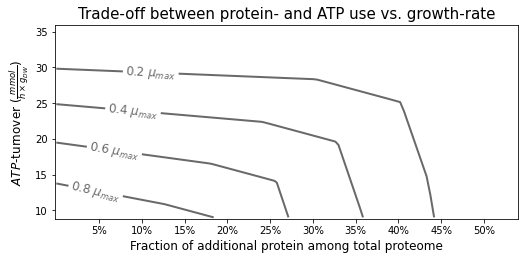

In [28]:
# plot results
def fmt(x):
    s = f"{x/100:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return(s+" $\\mu_{max}$")

fig=plt.figure(figsize=(8*0.92439,4.025*0.92439))
ax = fig.add_subplot(111)

CS20 = ax.contour(numpy.array(Results_Pareto["Protein"]), 
                 numpy.array(Results_Pareto["ATP"]), 
                 numpy.array(Results_Pareto["Growth-rate"]),
                 levels=[20], colors='dimgray', linewidths=2)
CS40 = ax.contour(numpy.array(Results_Pareto["Protein"]), 
                 numpy.array(Results_Pareto["ATP"]), 
                 numpy.array(Results_Pareto["Growth-rate"]), 
                 levels=[40], colors='dimgray', linewidths=2)
CS60 = ax.contour(numpy.array(Results_Pareto["Protein"]), 
                 numpy.array(Results_Pareto["ATP"]), 
                 numpy.array(Results_Pareto["Growth-rate"]),
                 levels=[60], colors='dimgray', linewidths=2)
CS80 = ax.contour(numpy.array(Results_Pareto["Protein"]), 
                 numpy.array(Results_Pareto["ATP"]), 
                 numpy.array(Results_Pareto["Growth-rate"]),
                 levels=[80], colors='dimgray', linewidths=2)

label20 = ax.clabel(CS20, inline=True, fontsize=12, fmt=fmt, rightside_up=False)
label40 = ax.clabel(CS40, inline=True, fontsize=12, fmt=fmt)
label60 = ax.clabel(CS60, inline=True, fontsize=12, fmt=fmt)
label80 = ax.clabel(CS80, inline=True, fontsize=12, fmt=fmt)

ax.set_ylim(8.8,36)
ax.set_xlim(-0.002,0.54)
ax.set_xticks([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
ax.set_xticklabels(["{}%".format(int(i*100)) for i in [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]])

ax.set_title("Trade-off between protein- and ATP use vs. growth-rate",fontsize=15)
ax.set_ylabel("$ATP$-turnover ($\\frac{mmol}{h \\times g_{DW}}$)",fontsize=12)
ax.set_xlabel("Fraction of additional protein among total proteome",fontsize=12)


plt.tight_layout()
plt.show()

## Kapp sampling - global sensitivity analysis
Here we sample N global sets of enzyme efficiencies, by drawing multiplicative factors for each enzyme's forward- and backward efficiency form a log-normal distribution (base: e). The wild-type efficiencies are then multiplied with this factor and the maximum growth-rate and corresponding exchange fluxes of glucose, oxygen and acetate are determined. 

#### --> Relevant rbatools.rba_session.SessionRBA methods used here, are 'add_parameter_multipliers_for_enzyme_efficiencies', 'set_medium' and 'sample_kapp_multipliers'.

In [ ]:
N_SAMPLES=15

STDEV_SAMPLING=numpy.log(1.1)
MEAN_SAMPLING=0

Simulation.reload_model()
Simulation.set_medium({'M_glc':0.025})

# add parameter multipliers for each enzyme efficiency (initialized as 1.0):
enzymes=Simulation.add_parameter_multipliers_for_enzyme_efficiencies()
# define variable names of decision variables in mudel to record for each sample:
Variables_to_record = ["R_EX_o2_e"]
# draw specified number of samples, from distribution with specified parameters and record specified decision variable each run
KappScreenResults=Simulation.sample_kapp_multipliers(n=N_SAMPLES,mean=MEAN_SAMPLING,stdev=STDEV_SAMPLING,enzymes=enzymes,Variables_to_record=Variables_to_record)



In [ ]:
# plot results
df=pandas.DataFrame(KappScreenResults)

fig, ax= plt.subplots(2, 1,figsize=(4,4))

seaborn.histplot(data=df.loc[(df["Mu"]!=4)&(df["Mu"]!=None)], x="Mu",ax=ax[0],alpha=0.3,color="dimgray", kde=False,line_kws={"linewidth":4,"alpha":1},bins=19,fill=True)
ax[0].set_xlabel("Growth rate ($h^{-1}$)")
ax[0].set_yticks([])
ax[0].set_ylabel("")

seaborn.histplot(data=df.loc[(df["R_EX_o2_e"]!=None)], x="R_EX_o2_e",ax=ax[1],alpha=0.3,color="indianred", kde=False,line_kws={"linewidth":4,"alpha":1},bins=15,fill=True)
ax[1].set_xlabel("$O_2$ uptake: ($\\frac{mmol}{h \\times g_{DW}}$)")
ax[1].set_yticks([])
ax[1].set_ylabel("")

ax[0].set_title("Cellular state variability from sampled enzyme efficiencies",fontsize=15)

plt.tight_layout()
plt.show()
